In [23]:
import os
import time
import datetime

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

/Users/richardchao/miniconda3/envs/cs182/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/richardchao/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
data_dir = "/Users/richardchao/Code/cs182-project/data/"
filename = 'spongebob_lines.csv'

In [7]:
df = pd.read_csv(data_dir + filename)
df

,Lines
0,"Hold on, I'll check the textbook. Ah, Your Mi..."
1,Hooray!
2,"Mrs. Puff! Oh, there you are. I'll make it up..."
3,I love cleaning!
4,That takes care of that. Yuck. This place nee...
...,...
12837,"Good night, Earth! Hey, I'm mooning you. Hell..."
12838,"Hey, mister! I can see your bald spot."
12839,"Don't be alarmed, people. I'm only here 'til D..."
12840,"Oh, sorry. Just gave away the big surprise, di..."


In [8]:
lines = df['Lines'].copy()
lines

0        Hold on, I'll check the textbook.  Ah, Your Mi...
1                                                  Hooray!
2        Mrs. Puff! Oh, there you are.  I'll make it up...
3                                         I love cleaning!
4        That takes care of that.  Yuck. This place nee...
                               ...                        
12837    Good night, Earth! Hey, I'm mooning you.  Hell...
12838               Hey, mister! I can see your bald spot.
12839    Don't be alarmed, people. I'm only here 'til D...
12840    Oh, sorry. Just gave away the big surprise, di...
12841    I don't know, Mr. Krabs, but I've got this str...
Name: Lines, Length: 12842, dtype: object

/var/folders/8r/09lwc9312jl_hr20wdddssrm0000gn/T/ipykernel_71181/2980121587.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(doc_lengths)


<Axes: ylabel='Density'>

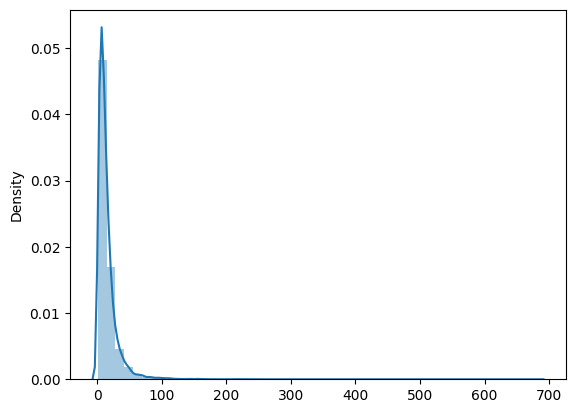

In [24]:
import nltk
doc_lengths = []

for line in lines:

    # get rough token count distribution
    tokens = nltk.word_tokenize(line)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [27]:
np.average(doc_lengths)

15.028110886154805

In [30]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium

vocab.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 24.1MB/s]
merges.txt: 100%|██████████| 456k/456k [00:00<00:00, 6.02MB/s]
tokenizer.json: 100%|██████████| 1.36M/1.36M [00:00<00:00, 5.66MB/s]
config.json: 100%|██████████| 665/665 [00:00<00:00, 1.87MB/s]


In [31]:
batch_size = 2

In [32]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [34]:
dataset = GPT2Dataset(lines, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

11,557 training samples
1,285 validation samples


In [35]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

## Finetuning

In [37]:
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)
# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
# device = torch.device("cuda")
# model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [38]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [40]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [41]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [42]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [45]:
total_t0 = time.time()

training_stats = []

model = model

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0]
        b_labels = batch[0]
        b_masks = batch[1]

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0]
        b_labels = batch[0]
        b_masks = batch[1]
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  5,779. Loss: 0.03799671307206154.   Elapsed: 0:26:00.
0:  bipartisanThe only words that will protect you from this, hate for the cops.
